Epoch 1/10 - Train Loss: 0.0104 - Val Loss: 0.0099 - Colorfulness: 0.0691
Epoch 2/10 - Train Loss: 0.0098 - Val Loss: 0.0096 - Colorfulness: 0.0679
Epoch 3/10 - Train Loss: 0.0097 - Val Loss: 0.0095 - Colorfulness: 0.0811
Epoch 4/10 - Train Loss: 0.0096 - Val Loss: 0.0094 - Colorfulness: 0.0782
Epoch 5/10 - Train Loss: 0.0096 - Val Loss: 0.0097 - Colorfulness: 0.0701
Epoch 6/10 - Train Loss: 0.0095 - Val Loss: 0.0095 - Colorfulness: 0.0848
Epoch 7/10 - Train Loss: 0.0095 - Val Loss: 0.0094 - Colorfulness: 0.0697
Epoch 8/10 - Train Loss: 0.0095 - Val Loss: 0.0094 - Colorfulness: 0.0850
Epoch 9/10 - Train Loss: 0.0094 - Val Loss: 0.0094 - Colorfulness: 0.0765
Epoch 10/10 - Train Loss: 0.0094 - Val Loss: 0.0093 - Colorfulness: 0.0771


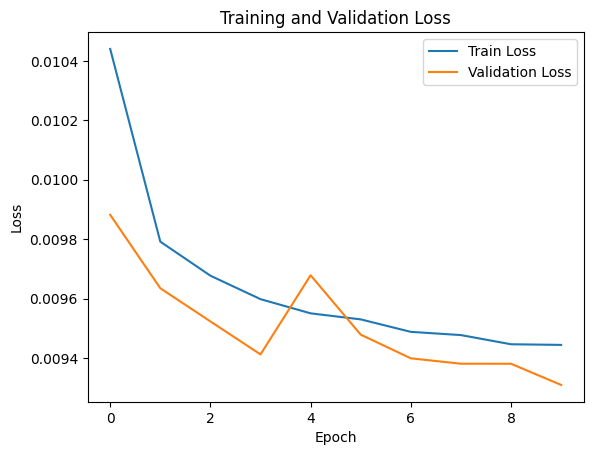

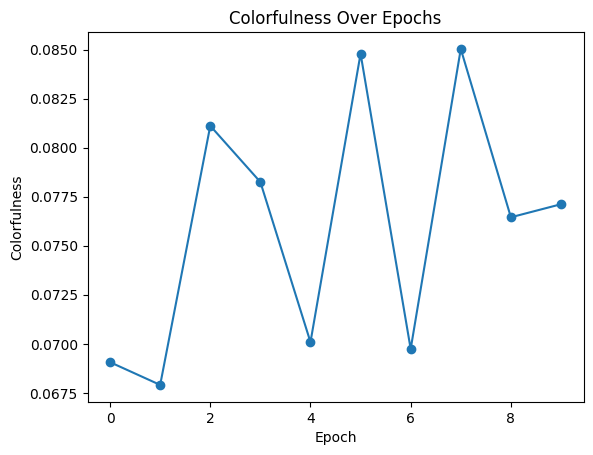

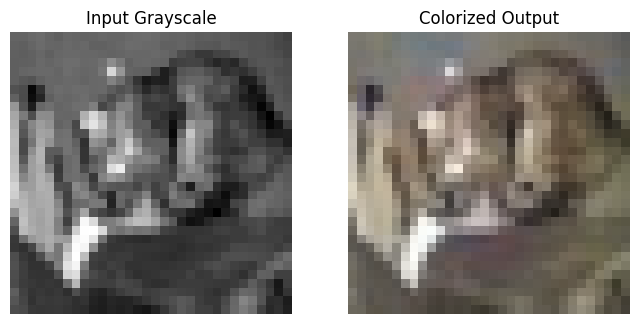

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

class ColorizationNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1), nn.ReLU(True),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(True),
            nn.MaxPool2d(2, 2)
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1), nn.ReLU(True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(64, 2, 3, padding=1), nn.Tanh()  # predicts ab channels scaled [-1,1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

def show_side_by_side(grayscale, color, title1='Grayscale', title2='Colorized'):
    fig, axs = plt.subplots(1, 2, figsize=(8,4))
    axs[0].imshow(grayscale.squeeze(), cmap='gray')
    axs[0].set_title(title1)
    axs[0].axis('off')
    axs[1].imshow(color)
    axs[1].set_title(title2)
    axs[1].axis('off')
    plt.show()

def plot_loss_curves(loss_logs):
    epochs = list(range(len(loss_logs['train'])))
    plt.plot(epochs, loss_logs['train'], label='Train Loss')
    plt.plot(epochs, loss_logs['val'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

def colorfulness_metric(img):
    rg = np.abs(img[..., 0] - img[..., 1])
    yb = np.abs(0.5*(img[..., 0] + img[..., 1]) - img[..., 2])
    std_rg = np.std(rg)
    std_yb = np.std(yb)
    mean_rg = np.mean(rg)
    mean_yb = np.mean(yb)
    return std_rg + std_yb + 0.3*(mean_rg + mean_yb)

def plot_colorfulness(colorfulness_values):
    plt.plot(colorfulness_values, marker='o')
    plt.title('Colorfulness Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Colorfulness')
    plt.show()

def rgb_to_lab_ab(tensor):
    rgb = tensor.permute(1, 2, 0).numpy()
    lab = rgb2lab(rgb)
    ab = lab[..., 1:] / 128.0
    return torch.tensor(ab).permute(2, 0, 1).float()

def lab_ab_to_rgb(l_channel, ab_channels):
    lab_img = np.zeros((l_channel.shape[0], l_channel.shape[1], 3))
    lab_img[..., 0] = l_channel
    lab_img[..., 1:] = ab_channels.transpose(1, 2, 0) * 128  # transpose ab to (H, W, 2)
    rgb_img = lab2rgb(lab_img)
    return np.clip(rgb_img, 0, 1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ColorizationNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])
cifar_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar_val = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar_val, batch_size=16, shuffle=False)

def train_model(model, train_loader, val_loader, epochs=10):
    loss_logs = {'train': [], 'val': []}
    colorfulness_vals = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for imgs, _ in train_loader:
            optimizer.zero_grad()
            batch_loss = 0
            for img in imgs:
                img = img.to(device)
                gray = transforms.functional.rgb_to_grayscale(img).unsqueeze(0).to(device)  # shape: [1,1,H,W]
                lab_img = rgb2lab(img.cpu().permute(1, 2, 0).numpy())
                l = torch.tensor(lab_img[..., 0]).unsqueeze(0).unsqueeze(0).to(device) / 100.0
                ab = rgb_to_lab_ab(img.cpu()).unsqueeze(0).to(device)

                output_ab = model(gray)
                loss = criterion(output_ab, ab)
                loss.backward()
                batch_loss += loss.item()
            optimizer.step()
            train_loss += batch_loss / len(imgs)
        train_loss /= len(train_loader)
        loss_logs['train'].append(train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for imgs, _ in val_loader:
                batch_val_loss = 0
                for img in imgs:
                    img = img.to(device)
                    gray = transforms.functional.rgb_to_grayscale(img).unsqueeze(0).to(device)
                    ab = rgb_to_lab_ab(img.cpu()).unsqueeze(0).to(device)
                    output_ab = model(gray)
                    loss = criterion(output_ab, ab)
                    batch_val_loss += loss.item()
                val_loss += batch_val_loss / len(imgs)
        val_loss /= len(val_loader)
        loss_logs['val'].append(val_loss)

        with torch.no_grad():
            sample_img, _ = next(iter(val_loader))
            sample_img = sample_img[0].to(device)
            gray = transforms.functional.rgb_to_grayscale(sample_img).unsqueeze(0).to(device)
            output_ab = model(gray).squeeze().cpu().numpy()
            l_channel = rgb2lab(sample_img.cpu().permute(1, 2, 0).numpy())[..., 0]
            color_img = lab_ab_to_rgb(l_channel, output_ab)
            colorfulness_vals.append(colorfulness_metric(color_img))

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - Colorfulness: {colorfulness_vals[-1]:.4f}")

    return loss_logs, colorfulness_vals

loss_logs, colorfulness_vals = train_model(model, train_loader, val_loader, epochs=10)
plot_loss_curves(loss_logs)
plot_colorfulness(colorfulness_vals)

# Visualize the colorization on a sample validation image
img, _ = cifar_val[0]
gray = transforms.functional.rgb_to_grayscale(img).unsqueeze(0).to(device)
with torch.no_grad():
    output_ab = model(gray).squeeze().cpu().numpy()
l_channel = rgb2lab(img.permute(1, 2, 0).numpy())[..., 0]
color_img = lab_ab_to_rgb(l_channel, output_ab)

show_side_by_side(gray.cpu().squeeze().numpy(), color_img, 'Input Grayscale', 'Colorized Output')
